In [6]:
# import sys
# !{sys.executable} -m pip install z3-solver
# !{sys.executable} -m pip install xacc-vqe
# !{sys.executable} -m pip install xacc

In [8]:
import z3
import qiskit
# import xacc
import matplotlib.pyplot as plt
import re

In [75]:
def QASMDict(gates):
#     print(gates)
    qasmDict = {} #  {'qbit number' : []}
#     print(gates)
    for x in range(len(gates)):
        if x == 1 or x == 0:
            continue
        if gates[x][0] == 'qreg':
            for y in range(int(gates[x][1][2])):
                qasmDict[str(y)] = []
        if gates[x][0] != 'OPENQASM' and gates[x][0] != 'include' and gates[x][0] != 'qreg' and gates[x][0] != 'creg' and gates[x][0] != 'measure':
            for z in range(len(gates[x])-1):
                qasmDict[str(gates[x][z+1][2])].append(gates[x])
    return qasmDict
        
            
QASMDict([['OPENQASM', '2.0'], ['include', '"qelib1.inc"'], ['qreg', 'q[2]'], ['creg', 'c[2]'], ['h', 'q[0]'], ['h', 'q[1]'], ['cz', 'q[1]', 'q[0]'], ['h', 'q[0]'], ['cx', 'q[1]', 'q[0]'], ['measure', 'q[0]', '->', 'c[0]'], ['measure', 'q[1]', '->', 'c[1]']])

{'0': [['h', 'q[0]'],
  ['cz', 'q[1]', 'q[0]'],
  ['h', 'q[0]'],
  ['cx', 'q[1]', 'q[0]']],
 '1': [['h', 'q[1]'], ['cz', 'q[1]', 'q[0]'], ['cx', 'q[1]', 'q[0]']]}

In [182]:
def HZHtoCNOTnew(qasm_loc, out_loc=None):
    
    qasm_f = open(qasm_loc, "r")

    gates = []
    for line in qasm_f:
        gates.append( list(filter(None, re.split(" |,", line.strip()[:-1]))) )
#     print(gates)
    qasmDict = QASMDict(gates)
    qasm_f.close()
    out_gates = []
    out_gates.append(['OPENQASM', '2.0'])
    out_gates.append(['include', '"qelib1.inc"'])
    out_gates.append(gates[2])
    out_gates.append(gates[3])
    print(qasmDict)

    for qbit in qasmDict:
        gate = 0
        while gate < len(qasmDict[qbit]):

            ## look for starting of an equivilency swap pattern
            if qasmDict[qbit][gate][0] == 'h':
                print(qasmDict[qbit][gate][0])
                ## check double hadamard
                try:
#                     print(int(qasmDict[qbit][gate + 1][2][2]))
                    if qasmDict[qbit][gate + 1][0] == 'h':
#                         print('double')
                        gate +=1
                        # dont append anything to out gates
                    elif qasmDict[qbit][gate + 1][0] == 'cz':
                        if int(qasmDict[qbit][gate + 1][2][2]) == int(qbit) and qasmDict[qbit][gate + 2][0] == 'h':
#                             print('we gottem bois')
                            out_gates.append(['cx', qasmDict[qbit][gate + 1][1], qasmDict[qbit][gate + 1][2]])
#                             print(gate)
                            gate +=2
#                             print(gate)
                        else:
                            out_gates.append(qasmDict[qbit][gate])
                    else:
                        out_gates.append(qasmDict[qbit][gate])
                except:
#                     print('last gate, cannot swap')
#                     print(qasmDict[qbit][gate])
                    out_gates.append(qasmDict[qbit][gate])
            else:
                if qasmDict[qbit][gate][0][0] == 'c':
                    if int(qasmDict[qbit][gate][2][2]) == int(qbit):
                        out_gates.append(qasmDict[qbit][gate])
                else:
                    out_gates.append(qasmDict[qbit][gate])
            gate += 1
#         print('end qbit')
    for i in gates:
        if i[0] == 'measure':
            out_gates.append(i)
#     print(out_gates)
    out_txt = ''
    for line in out_gates:
        if len(line) > 2:
            for l in range(1, len(line)-1):
                if line[l][:2] == 'q[' and line[l+1][:2] == 'q[':
                    line[l] = line[l] + ','

        out_txt += ' '.join(line) + ';' + '\n'
    return out_txt
print(HZHtoCNOTnew('circuit.qasm'))

{'0': [['cx', 'q[1]', 'q[0]']], '1': [['cx', 'q[1]', 'q[0]'], ['h', 'q[1]']]}
h
OPENQASM 2.0;
include "qelib1.inc";
qreg q[2];
creg c[2];
cx q[1], q[0];
h q[1];
measure q[0] -> c[0];
measure q[1] -> c[1];



In [150]:
# outputs replaced qasm circuit in a string
def HZHtoCNOT(qasm_loc, out_loc=None):
    
    qasm_f = open(qasm_loc, "r")

    gates = []
    for line in qasm_f:
        gates.append( list(filter(None, re.split(" |,", line.strip()[:-1]))) )
#     print(gates)
    qasm_f.close()

    out_gates = []

    qubits = 0
    line_num = 0
    gate_iter = iter(gates)

    for line in gate_iter:
        if line[0] == 'qreg':
            qubits = int(line[1][2])
            out_gates.append(line)

        elif line[0] == 'h':
            gate1 = line[1]
            next_line = gates[line_num + 1]
            if next_line[0] != 'cz' or next_line[2] != gate1:
                out_gates.append(line)
            else:
                next_next_line = gates[line_num + 2]
                if next_next_line[0] != 'h' or next_next_line[1] != gate1:
                    out_gates.append(line)
                else:
                    out_gates.append(['cx', next_line[1], gate1])
                    next(gate_iter)
                    next(gate_iter)

        else:
            out_gates.append(line)

        line_num += 1
    
    out_txt = ""
    print(out_gates)
    for line in out_gates:
        if len(line) > 2:
            for l in range(1, len(line)-1):
                if line[l][:2] == 'q[' and line[l+1][:2] == 'q[':
                    line[l] = line[l] + ','

        out_txt += ' '.join(line) + ';' + '\n'
    
    if (out_loc != None):
        try:
            with open(out_loc, 'w') as out_file: out_file.write(out_txt) 
        except:
            print('Output file write failed!')
    

    return out_txt

In [183]:
qasm_loc = 'circuit.qasm'
out_txt = HZHtoCNOTnew(qasm_loc)
print(out_txt)

{'0': [['cx', 'q[1]', 'q[0]']], '1': [['cx', 'q[1]', 'q[0]'], ['h', 'q[1]']]}
h
OPENQASM 2.0;
include "qelib1.inc";
qreg q[2];
creg c[2];
cx q[1], q[0];
h q[1];
measure q[0] -> c[0];
measure q[1] -> c[1];



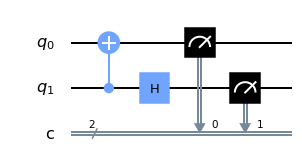

In [184]:
circ = qiskit.QuantumCircuit.from_qasm_file('circuit.qasm')
circ.draw(output='mpl')

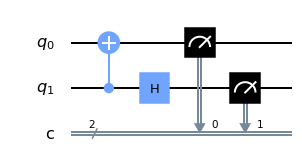

In [185]:
circ_out = qiskit.QuantumCircuit.from_qasm_str(out_txt)
circ_out.draw(output='mpl')

In [173]:
# circ = qiskit.QuantumCircuit.from_qasm_file('circuit_out.qasm')
# circ.draw(output='mpl')

In [143]:
# # Test
# # Not for edge cases

# qasm_f = open("circuit.qasm", "r")

# gates = []
# for line in qasm_f:
#     gates.append( list(filter(None, re.split(" |,", line.strip()[:-1]))) )

# qasm_f.close()

# out_gates = []

# qubits = 0
# line_num = 0
# gate_iter = iter(gates)

# for line in gate_iter:
#     if line[0] == 'qreg':
#         qubits = int(line[1][2])
#         out_gates.append(line)
    
#     elif line[0] == 'h':
#         gate1 = line[1]
#         next_line = gates[line_num + 1]
#         if next_line[0] != 'cz' or next_line[2] != gate1:
#             out_gates.append(line)
#         else:
#             next_next_line = gates[line_num + 2]
#             if next_next_line[0] != 'h' or next_next_line[1] != gate1:
#                 out_gates.append(line)
#             else:
#                 out_gates.append(['cx', next_line[1], gate1])
#                 next(gate_iter)
#                 next(gate_iter)
    
#     else:
#         out_gates.append(line)
    
#     line_num += 1
    


In [155]:
# gates

In [156]:
# out_gates

In [157]:
# out_txt = ""
# for line in out_gates:
#     if len(line) > 2:
#         for l in range(1, len(line)-1):
#             if line[l][:2] == 'q[' and line[l+1][:2] == 'q[':
#                 line[l] = line[l] + ','
    
#     out_txt += ' '.join(line) + ';' + '\n'
    
# print(out_txt)

In [158]:
# # Test
# # import qiskit as q



# # circuit = q.QuantumCircuit(2,2)
# # circuit.x(0)
# #
# # circuit.draw()

# def convertListQasm(list):
#     qasm = ''
#     for x in list:
#         if x == '':
#             continue
#         qasm += x + ';\n'
#     return qasm



# f = open('circuit.qasm', 'r')
# qasmStr = f.read()
# qasmList = qasmStr.split(';\n')
# print(convertListQasm(qasmList))
# print(qasmList)
# index = 2
# numQ = 0
# numC = 0
# totalList = []
# while index < len(qasmList):
#     line = qasmList[index].split(' ')
#     if (qasmList[index] == ''):
#         index += 1
#         continue
#     elif line[0] == 'qreg':
#         numQ = int(qasmList[index].split(' ')[1][2])
#     elif line[0] == 'creg':
#         numC = int(qasmList[index].split(' ')[1][2])
#     elif line[0] == 'h':
#         # its hadimard, check next to see if its hadimard as well then can get rid of both
#     elif line[0] == 'z':
#         # its z gate, check if next is the z gate
#     elif line[0] == 'cz':
#         # controlled z gates, can swap the qubits feeding the gates
#         # check gate before and after to see if its hadimard, and if so swap all 3 with cx
#     elif line[0] == '':
#         #
#     print(qasmList[index])
#     index += 1
    
# print(numC)